In [1]:
#!pip install ib_insync
#!pip install bs4
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import quantstats as qs

from utils import *

In [5]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=19)

<IB connected to 127.0.0.1:7497 clientId=19>

Peer closed connection.


In [6]:
ib.run()

In [7]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [8]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1049322.91
Cash: 1040262.53


In [219]:
test_ticker = 'AAPL'

In [235]:
stock = Stock(test_ticker, 'SMART', 'USD', primaryExchange='NASDAQ')
bars = ib.reqHistoricalData(stock, endDateTime = '', durationStr = '2 W', barSizeSetting = '5 mins', whatToShow = 'ADJUSTED_LAST', useRTH = True, formatDate = 2)

In [236]:
print(stock)

Stock(symbol='AAPL', exchange='SMART', primaryExchange='NASDAQ', currency='USD')


In [237]:
ib.qualifyContracts(stock)

[Stock(conId=265598, symbol='AAPL', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='AAPL', tradingClass='NMS')]

In [238]:
dfBars = util.df(bars)
# dfBars = dfBars.set_index('date')
dfBars

,date,open,high,low,close,volume,average,barCount
0,2024-05-22 13:30:00+00:00,192.38,192.45,191.98,192.37,1062779.0,192.280,3330
1,2024-05-22 13:35:00+00:00,192.37,192.79,192.35,192.43,664559.0,192.558,3033
2,2024-05-22 13:40:00+00:00,192.43,192.46,192.06,192.16,406108.0,192.261,2028
3,2024-05-22 13:45:00+00:00,192.18,192.39,192.08,192.26,291350.0,192.256,1463
4,2024-05-22 13:50:00+00:00,192.25,192.50,192.12,192.47,319059.0,192.329,1603
...,...,...,...,...,...,...,...,...
697,2024-06-04 19:35:00+00:00,194.61,194.62,194.33,194.46,304803.0,194.494,1689
698,2024-06-04 19:40:00+00:00,194.46,194.79,194.45,194.78,319999.0,194.619,1672
699,2024-06-04 19:45:00+00:00,194.78,194.87,194.41,194.78,409366.0,194.692,2187
700,2024-06-04 19:50:00+00:00,194.78,194.85,194.23,194.26,694031.0,194.534,4131


In [239]:
import typing
import pandas as pd
import numpy as np
import numpy.typing as npt
from utils import load_financial_data
from markov import *
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from models import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [240]:
from utils import load_financial_data, plot_ts, plot_multi_ts

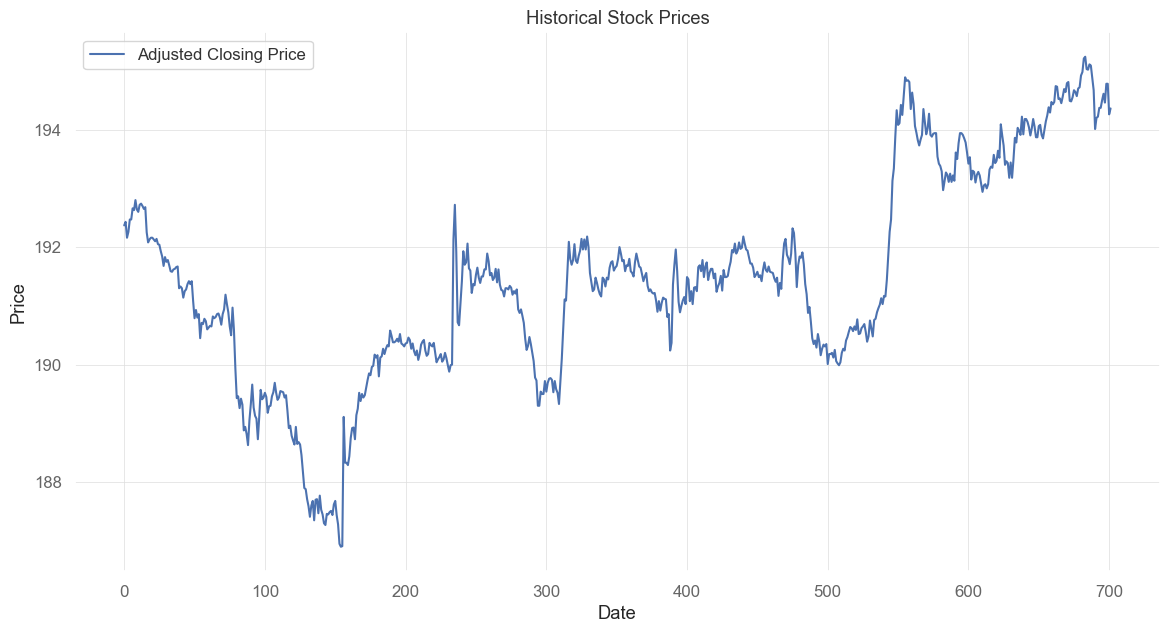

In [241]:
plot_ts(
    data=dfBars["close"], 
    title=f"Historical Stock Prices",
    label_ts="Adjusted Closing Price",
    x_label="Date",
    y_label="Price",
)

In [242]:
security_data = dfBars

In [243]:
from ml import *

In [244]:
markovian_strategy = MLStrategy(
        price=security_data[:-200]["close"],
        valid_data=security_data[-200:]["close"],
        test_data=security_data[-200:]["close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=15,
        forward=3,
    )

In [245]:
markovian_strategy.train(
    epochs=100,
    lr=1e-3,
)

100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


In [246]:
markovian_performance = markovian_strategy.backtest(
    initial_cash=2e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=10,
    allin=False,
    halfin=False,
)
markovian_performance

  0%|          | 0/186 [00:00<?, ?it/s]

100%|██████████| 186/186 [00:00<00:00, 808.26it/s]


,price,daily_return,signals,cash,positions,wealth
502,190.18,1.000000,0,2000.00,0.00,2000.00
503,190.20,0.000105,0,2000.00,0.00,2000.00
504,190.12,-0.000421,0,2000.00,0.00,2000.00
505,190.25,0.000684,0,2000.00,0.00,2000.00
506,190.06,-0.000999,0,2000.00,0.00,2000.00
...,...,...,...,...,...,...
697,194.46,-0.000771,0,1227.04,777.84,2004.88
698,194.78,0.001646,0,1227.04,779.12,2006.16
699,194.78,0.000000,0,1227.04,779.12,2006.16
700,194.26,-0.002670,0,1227.04,777.04,2004.08


In [232]:
import matplotlib.pyplot as plt

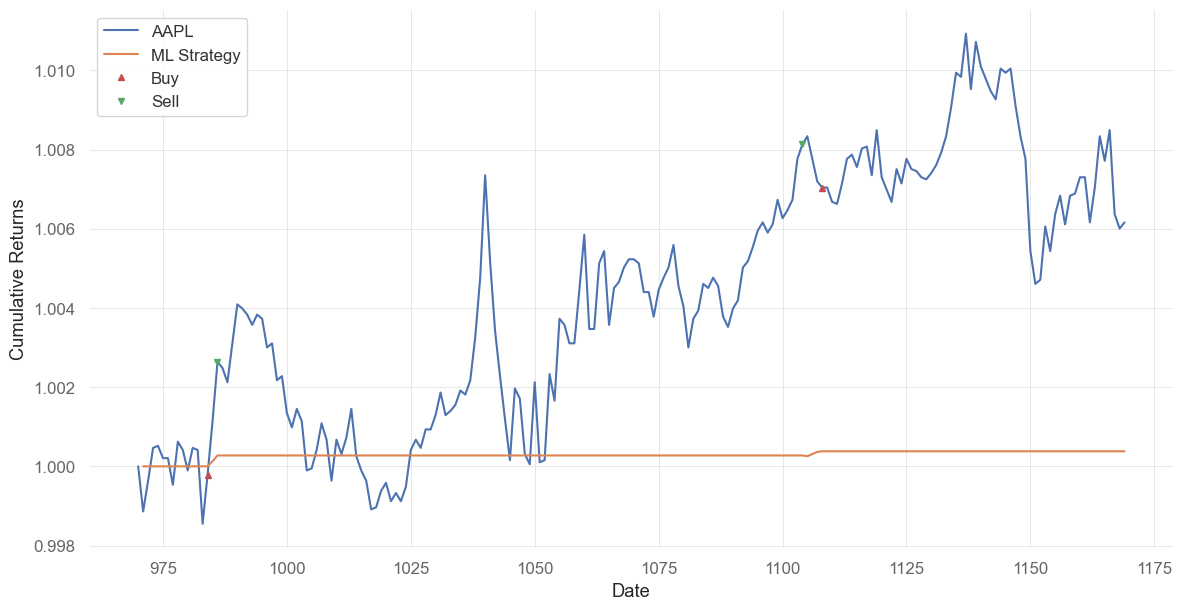

In [233]:
price = security_data[-200:]["close"]
# price = security_data["Adj Close"]

# Plot both cumulative returns on the same chart 
plt.figure(figsize=(14, 7)) 
plt.plot(price.index, price / price.iloc[0], label=test_ticker) 
plt.plot(markovian_performance.index, (1 + markovian_performance.wealth.pct_change()).cumprod(), label='ML Strategy')

plt.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, (price / price.iloc[0])[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
plt.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, (price / price.iloc[0])[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")


plt.xlabel('Date') 
plt.ylabel('Cumulative Returns') 
plt.legend() 
plt.show()

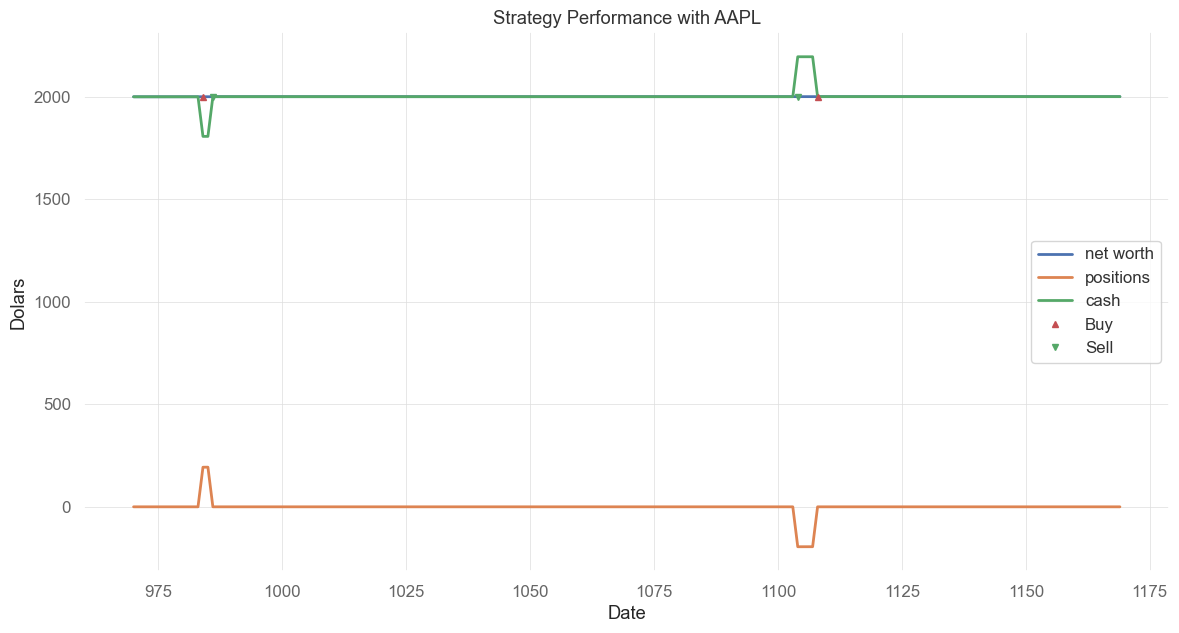

In [234]:
buy_and_hold = price

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111, ylabel = 'Price in USD')
markovian_performance.wealth.plot(ax=ax1, lw=2., label="net worth")
markovian_performance.positions.plot(ax=ax1, lw=2., label="positions")
markovian_performance.cash.plot(ax=ax1, lw=2., label="cash")

ax1.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, markovian_performance.wealth[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
ax1.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, markovian_performance.wealth[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")

plt.xlabel("Date")
plt.ylabel("Dolars")
plt.title(f"Strategy Performance with {test_ticker}")
plt.legend()
plt.show()

In [24]:
ib.sleep(0)
# Use this code to update the transmitted information

True

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import datetime
datetime.datetime.now().time() >= datetime.time(4, 50)
datetime.datetime.now().time() >= datetime.time(0, 43)

True

In [24]:
markovian_performance = markovian_strategy.deploy(
    ib=ib,
    ticker="NVDA",
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    freq=5,
    allin=False,
    halfin=False,
)
markovian_performance

KeyboardInterrupt: 

In [ ]:
markovian_performance.to_csv("result-META.csv")